# Evaluation of U-Net segmentation performance
* Data: X-ray angiogram
* Model: Pytorch-UNet
* Training: used 20 batch size and saved for 20 epochs

In [133]:
import sys
sys.path.append('..')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFilter, ImageChops
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

In [138]:
# helper functions

def create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created successfully.")
#     else:
#         print(f"Folder '{folder_path}' already exists.")
        
def get_paths(project_path, dataset, epoch_ver):
    img_path = data_path + dataset + '/imgs/'
    mask_path = data_path + dataset + '/masks/'
    pred_path = data_path + dataset + f'/predict/{epoch_ver[0]}_{epoch_ver[1]}/'
    create_folder(pred_path)    
    return img_path, mask_path, pred_path

def plot_img_mask_pred(dataset, path, img_num, epoch_ver):
    titles = ['imgs', 'masks', 'predict']
    
    fig,axs = plt.subplots(1, 3, figsize = (9,3))
    for i, title in enumerate(titles):    
        if i == 0:
            p = f'{path}/{title}'
            f = f'img_{img_num}.png'
        elif i == 1:
            p = f'{path}/{title}'
            f = f'img_{img_num}_mask.png'
        else:
            p = f'{path}/{title}/{epoch_ver[0]}_{epoch_ver[1]}'
            f = f'img_{img_num}_predict.png'            
            
        with Image.open(os.path.join(p, f)) as img:
            t = f'{dataset}, {title}'
            t = f'{t}, {epoch_ver[1]}' if i == 2 else t 
            axs[i].imshow(img)
            axs[i].set_title(t)

def intersection_over_union(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    iou = intersection / (union + 1e-7)  # Add a small epsilon to avoid division by zero
    return iou

def calculate_metrics(y_true, y_pred):
    # Flatten the ground truth and predicted masks
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat)
    recall = recall_score(y_true_flat, y_pred_flat)
    f1 = f1_score(y_true_flat, y_pred_flat)
    jaccard = jaccard_score(y_true_flat, y_pred_flat)
    iou = intersection_over_union(y_true_flat, y_pred_flat)

    return accuracy, precision, recall, f1, jaccard, iou
    
def save_results():
    pass

def plot_results():
    pass

# Visualize & evaluate with examples
* train vs test
* compare img, mask, prediction

train, img_4029, epoch1
accuracy=0.978, precision=0.983, recall=0.977, f1=0.980, jaccard=0.961, iou=0.961
train, img_2183, epoch20
accuracy=0.986, precision=0.985, recall=0.990, f1=0.988, jaccard=0.976, iou=0.976
test, img_7061, epoch1
accuracy=0.985, precision=0.980, recall=0.978, f1=0.979, jaccard=0.958, iou=0.958
test, img_1271, epoch20
accuracy=0.983, precision=0.961, recall=0.988, f1=0.975, jaccard=0.950, iou=0.950


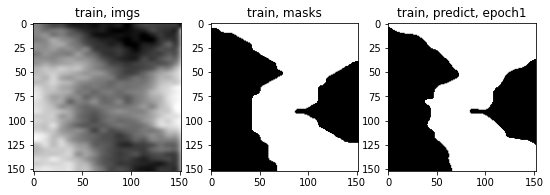

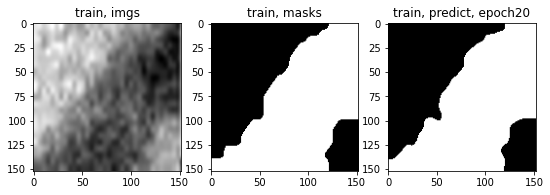

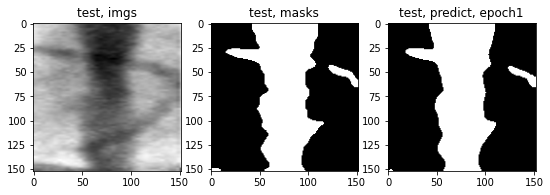

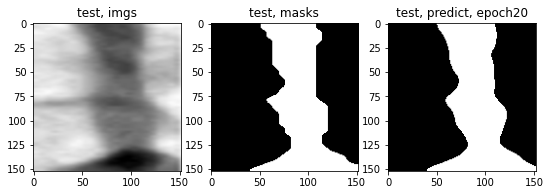

In [176]:
# dataset paths
project_path = '/home/ubuntu/project/Pytorch-UNet/'
data_path = project_path + 'data_xray/'

# user params
datasets = ['train', 'test']
epoch_vers = [['v3', 'epoch1'], ['v3', 'epoch20']]

# Create an empty DataFrame
metric_df1 = pd.DataFrame(columns=['dataset', 'img_num', 'epoch', 'accuracy', 
                                  'precision', 'recall', 'f1', 'jaccard', 'iou'])

# get paths and files
for dataset in datasets:
    for epoch_ver in epoch_vers:      
        img_path, mask_path, pred_path = get_paths(data_path, dataset, epoch_ver)

        #randomly choose files
        file = random.sample(os.listdir(pred_path), 1)[0]     
        img_num = file[4:-12]

        # Calculate evaluation metrics
        with Image.open(os.path.join(mask_path, f'img_{img_num}_mask.png')) as img:
            y_true = np.array(img)
            
        with Image.open(os.path.join(pred_path, f'img_{img_num}_predict.png')) as img:
            y_pred = np.array(img)    
    
        accuracy, precision, recall, f1, jaccard, iou = calculate_metrics(y_true, y_pred)   
        print('='*100)
        print(f'{dataset}, img_{img_num}, {epoch_ver[1]}')
        msg = f'accuracy={accuracy:.3f}, precision={precision:.3f}, recall={recall:.3f}, '
        msg += f'f1={f1:.3f}, jaccard={jaccard:.3f}, iou={iou:.3f}'
        print(msg)
        
        # Append IOU value to the DataFrame
        metric_df1 = metric_df1.append({'dataset': dataset, 'img_num': int(img_num), 'epoch': int(epoch_ver[1][5:]), 
                        'accuracy': accuracy, 'precision': precision, 'recall': recall,
                        'f1': f1, 'jaccard': jaccard, 'iou': iou}, ignore_index=True)
        
        # select one example and plot
        path = f'{data_path}{dataset}'
        plot_img_mask_pred(dataset, path, img_num, epoch_ver)     

In [177]:
metric_df1

,dataset,img_num,epoch,accuracy,precision,recall,f1,jaccard,iou
0,train,4029,1,0.978099,0.983250,0.976737,0.979983,0.960751,0.960751
1,train,2183,20,0.986106,0.985050,0.990163,0.987600,0.975504,0.975504
2,test,7061,1,0.984894,0.979709,0.977677,0.978692,0.958274,0.958274
3,test,1271,20,0.983033,0.961405,0.988009,0.974526,0.950317,0.950317


# Evaluation with the entire dataset
* train vs test, per each epoch
* metrics: accuracy, precision, recall, f1, jaccard, iou

In [172]:
# user params

datasets = ['train', 'test']
epoch_vers = [['v3', f'epoch{i}'] for i in range(1, 21)]

# Create an empty DataFrame
metric_df = pd.DataFrame(columns=['dataset', 'img_num', 'epoch', 'accuracy', 
                                  'precision', 'recall', 'f1', 'jaccard', 'iou'])
# get paths and files
for dataset in datasets:
    for epoch_ver in epoch_vers:
        img_path, mask_path, pred_path = get_paths(data_path, dataset, epoch_ver)

        #randomly choose files
        files = os.listdir(pred_path)
        
        for file in files:
            img_num = file[4:-12]

            # Calculate evaluation metrics
            with Image.open(os.path.join(mask_path, f'img_{img_num}_mask.png')) as img:
                y_true = np.array(img)

            with Image.open(os.path.join(pred_path, f'img_{img_num}_predict.png')) as img:
                y_pred = np.array(img)    

            accuracy, precision, recall, f1, jaccard, iou = calculate_metrics(y_true, y_pred)   

            # Append metric values to the DataFrame
            metric_df = metric_df.append(
                {'dataset': dataset, 'img_num': int(img_num), 'epoch': int(epoch_ver[1][5:]), 
                            'accuracy': accuracy, 'precision': precision, 'recall': recall,
                            'f1': f1, 'jaccard': jaccard, 'iou': iou}, ignore_index=True) 
            
# Save the DataFrame to a CSV file
metric_df.to_csv(f'eval_metric_v3.csv', index=False)

In [173]:
metric_df

,dataset,img_num,epoch,accuracy,precision,recall,f1,jaccard,iou
0,train,5209,1,0.985976,0.982047,0.993124,0.987555,0.975415,0.975415
1,train,7158,1,0.980912,0.983947,0.969019,0.976426,0.953938,0.953938
2,train,7087,1,0.988963,0.981366,0.991239,0.986278,0.972927,0.972927
3,train,4863,1,0.976714,0.966111,0.973515,0.969799,0.941369,0.941369
4,train,5569,1,0.967625,0.974480,0.973806,0.974143,0.949589,0.949589
...,...,...,...,...,...,...,...,...,...
3995,test,4741,20,0.986582,0.985231,0.991237,0.988225,0.976723,0.976723
3996,test,5991,20,0.980566,0.972153,0.987449,0.979741,0.960287,0.960287
3997,test,3461,20,0.987448,0.961292,0.964258,0.962773,0.928218,0.928218
3998,test,6761,20,0.989050,0.985770,0.991679,0.988716,0.977684,0.977684


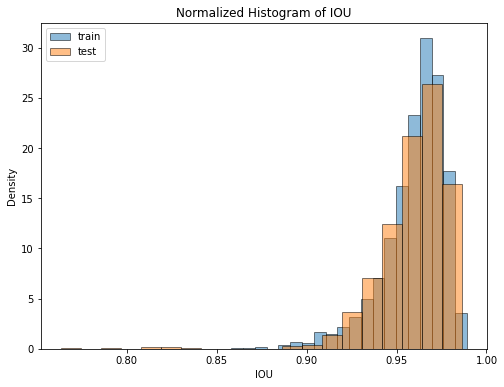

In [213]:
import matplotlib.pyplot as plt

# Assuming metric_df is your DataFrame

# Get unique dataset values
unique_datasets = metric_df['dataset'].unique()

# Create a figure and axes objects with specified figsize
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the values (width, height) as per your preference

# Plot histogram for each dataset separately
for dataset in unique_datasets:
    # Filter DataFrame based on dataset value
    dataset_values = metric_df[metric_df['dataset'] == dataset]['iou']
    
    # Plot histogram for the dataset with normalization
    ax.hist(dataset_values, bins=20, alpha=0.5, edgecolor='black', density=True, label=dataset)  # Add density=True for normalization
    
ax.set_xlabel('IOU')
ax.set_ylabel('Density')
ax.set_title('Normalized Histogram of IOU')
ax.legend()  # Add legend to differentiate datasets
plt.show()


In [191]:
mean_df = metric_df.groupby(['dataset', 'epoch']).mean().reset_index()
median_df = metric_df.groupby(['dataset', 'epoch']).median().reset_index()
std_df = metric_df.groupby(['dataset', 'epoch']).std().reset_index()

In [192]:
mean_df

,dataset,epoch,accuracy,precision,recall,f1,jaccard,iou
0,test,1,0.982013,0.975574,0.984179,0.979804,0.960611,0.960611
1,test,2,0.980263,0.991123,0.965214,0.977942,0.956961,0.956961
2,test,3,0.981052,0.981735,0.976225,0.978940,0.958965,0.958965
3,test,4,0.979645,0.982127,0.974973,0.978515,0.958073,0.958073
4,test,5,0.981637,0.983855,0.975298,0.979534,0.960031,0.960031
5,test,6,0.979690,0.985592,0.967734,0.976490,0.954376,0.954376
6,test,7,0.982096,0.976495,0.984497,0.980454,0.961795,0.961795
7,test,8,0.980955,0.985304,0.970679,0.977782,0.956985,0.956985
8,test,9,0.982697,0.981135,0.980112,0.980602,0.962072,0.962072
9,test,10,0.981465,0.985260,0.973647,0.979392,0.959776,0.959776


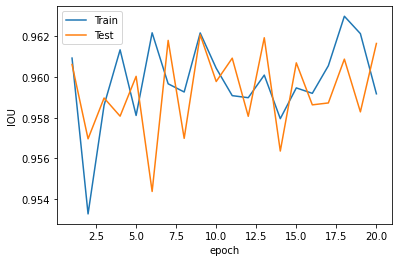

In [200]:
train_mean_df = mean_df[mean_df['dataset'] == 'train']
test_mean_df = mean_df[mean_df['dataset'] == 'test']

# Plot the IOU values
plt.plot(train_mean_df['epoch'], train_mean_df['iou'], label='train')
plt.plot(test_mean_df['epoch'], test_mean_df['iou'], label='test')
plt.legend(['Train', 'Test'])
plt.xlabel('epoch')
plt.ylabel('IOU')
plt.show()

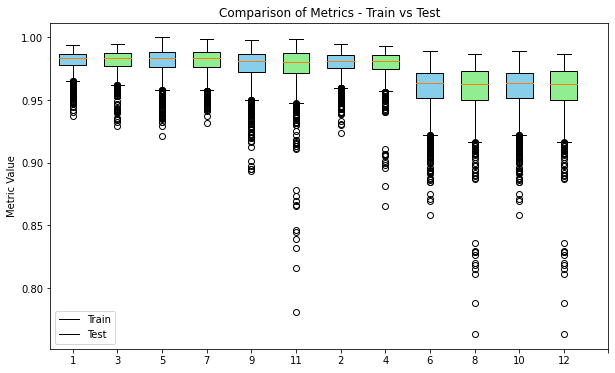

In [218]:
import matplotlib.pyplot as plt

# Assuming metric_df is your DataFrame

# Get unique metrics
metrics = ['accuracy', 'precision', 'recall', 'f1', 'jaccard', 'iou']

# Create a list to store the metric values for each dataset
train_metric_values = []
test_metric_values = []

# Iterate over the metrics
for metric in metrics:
    # Get the metric values for the train dataset
    train_values = metric_df[metric_df['dataset'] == 'train'][metric]
    train_metric_values.append(train_values)
    
    # Get the metric values for the test dataset
    test_values = metric_df[metric_df['dataset'] == 'test'][metric]
    test_metric_values.append(test_values)

# Create a figure and axes objects
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the size as per your preference

# Plot the box plots for each metric
ax.boxplot(train_metric_values, positions=range(1, len(metrics) * 2 + 1, 2), widths=0.6, patch_artist=True, boxprops=dict(facecolor='skyblue'))
ax.boxplot(test_metric_values, positions=range(2, len(metrics) * 2 + 2, 2), widths=0.6, patch_artist=True, boxprops=dict(facecolor='lightgreen'))

# Set the x-axis labels and ticks
ax.set_xticks(range(1, len(metrics) * 2 + 2))
# ax.set_xticklabels(metrics)

# Set the y-axis label and title
ax.set_ylabel('Metric Value')
ax.set_title('Comparison of Metrics - Train vs Test')

# Add a legend
ax.legend(['Train', 'Test'])

# Show the plot
plt.show()


# Predict with negative (unselected) data
* N = 10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


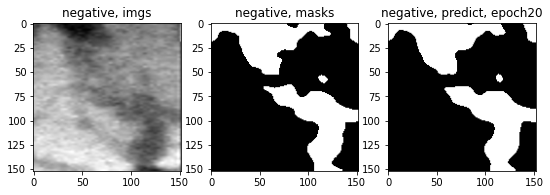

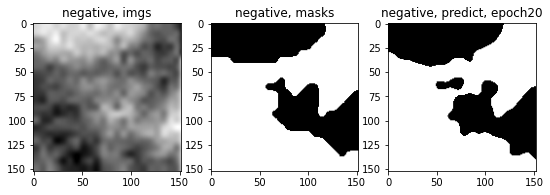

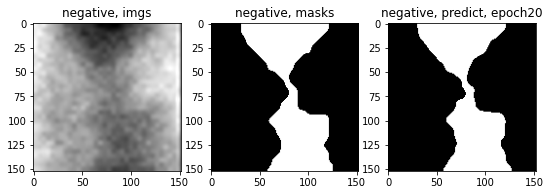

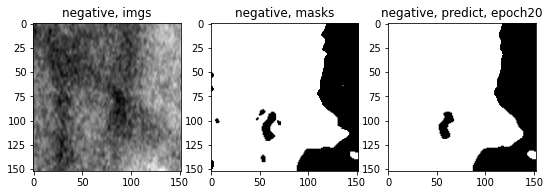

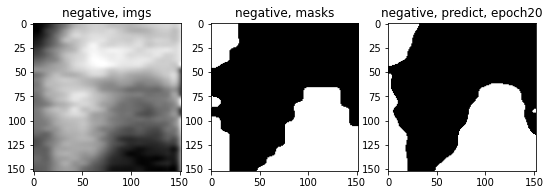

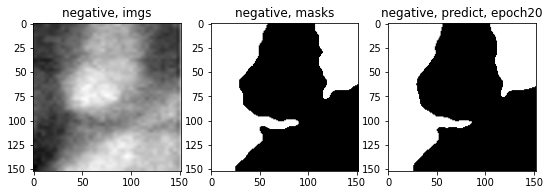

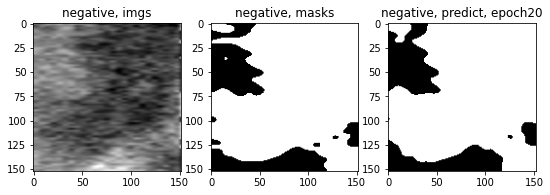

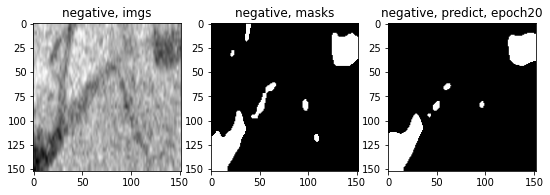

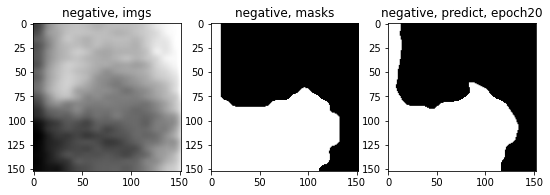

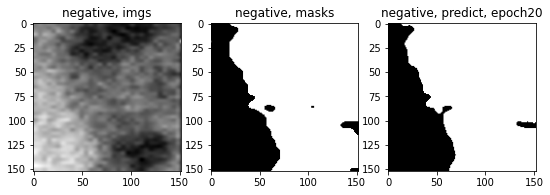

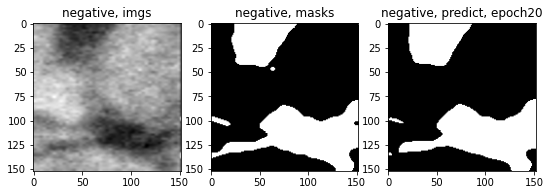

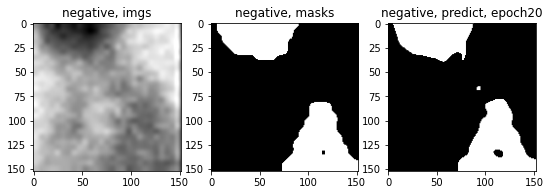

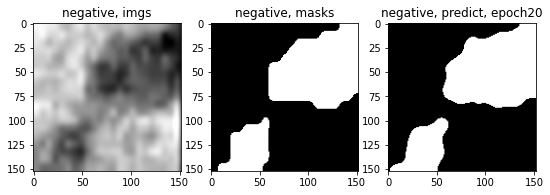

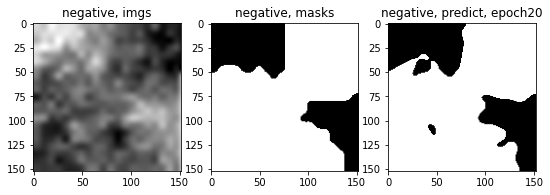

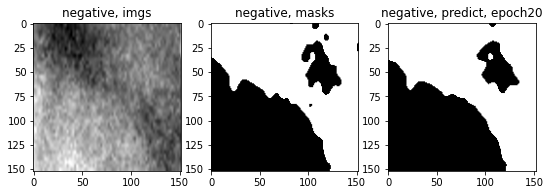

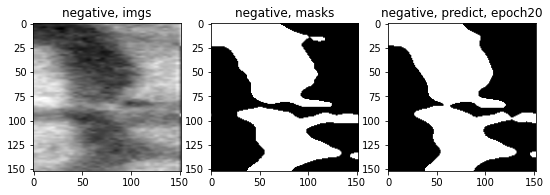

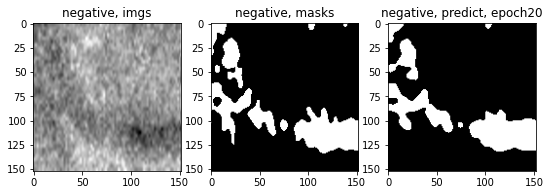

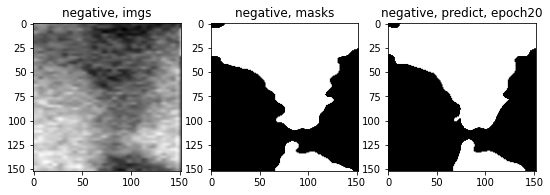

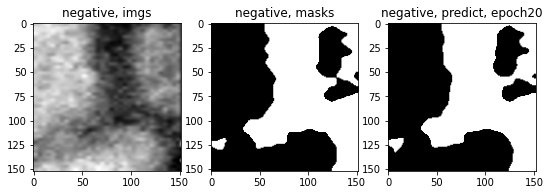

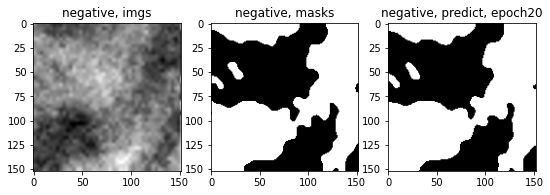

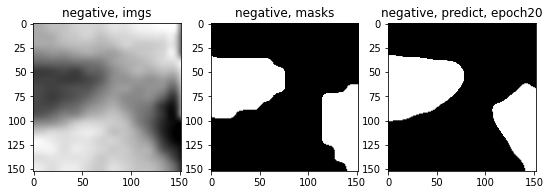

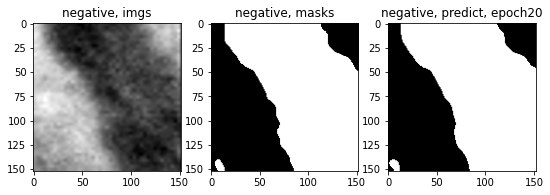

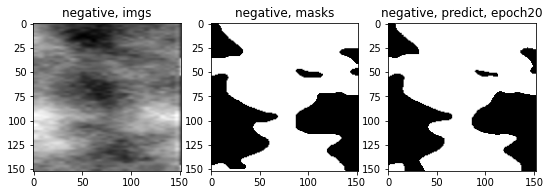

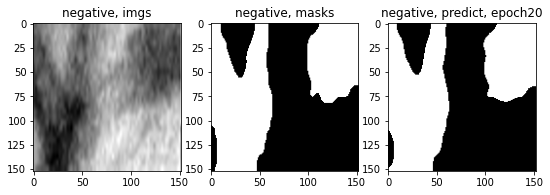

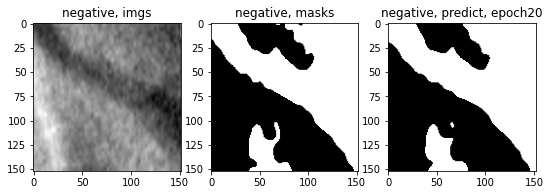

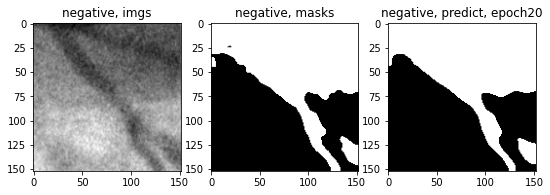

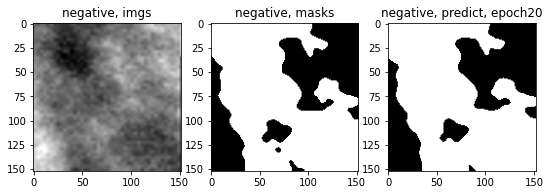

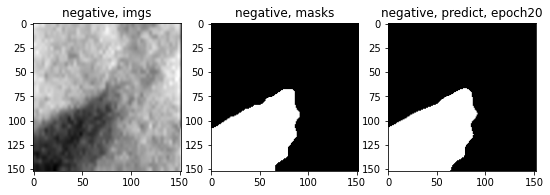

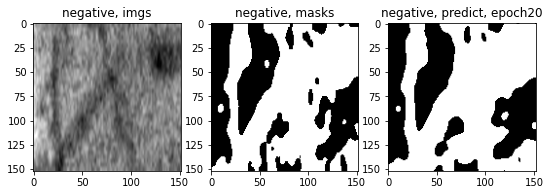

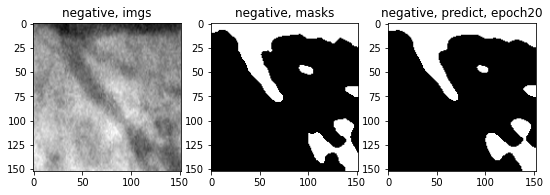

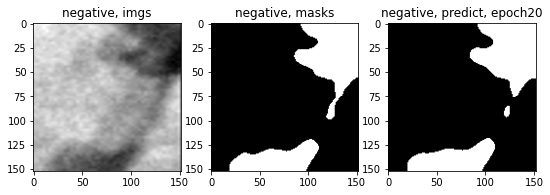

In [205]:
# dataset paths
project_path = '/home/ubuntu/project/Pytorch-UNet/'
data_path = project_path + 'data_xray/'

# user params
datasets = 'negative'
epoch_vers = ['v3', 'epoch1']

# get paths and files

img_path, mask_path, pred_path = get_paths(data_path, dataset, epoch_ver)

#randomly choose files
files = os.listdir(pred_path)    

for file in files:
    img_num = file[4:-12]

    # Calculate evaluation metrics
    with Image.open(os.path.join(mask_path, f'img_{img_num}_mask.png')) as img:
        y_true = np.array(img)

    with Image.open(os.path.join(pred_path, f'img_{img_num}_predict.png')) as img:
        y_pred = np.array(img)    

    # select one example and plot
    path = f'{data_path}{dataset}'
    plot_img_mask_pred(dataset, path, img_num, epoch_ver)     